# Практическое задание №2 

## Общая терминология по используемым данным

Предоставляемые данные для разработки моделей и алгоритмов трекинга мяча в теннисе представляют собор набор игр (game), состоящих из нескольких клипов (clip), каждый из которых состоит из набора кадров (frame). Обратите внимание на структуру организации файлов внутри предоставляемого датасета для полного понимания.

Большинство алгоритмов трекинга объектов работают с несколькими последовательными кадрами, и в данном задании также подразумевается использование этого приема. Последовательность нескольких кадров будем именовать стопкой (stack), размер стопки (stack_s) является гиперпараметром разрабатываемого алгоритма.

# Заготовка решения

## Загрузка датасета
Для работы с данными в ноутбуке kaggle необходимо подключить датасет. File -> Add or upload data, далее в поиске написать tennis-tracking-assignment и выбрать датасет. Если поиск не работает, то можно добавить датасет по url: https://www.kaggle.com/xubiker/tennistrackingassignment. После загрузки данные датасета будут примонтированы в ../input/tennistrackingassignment.

## Установка и импорт зависимостей

Установка необходимых пакетов (не забудьте "включить интернет" в настройках ноутбука kaggle):

In [1]:
!pip install moviepy --upgrade
!pip install gdown 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 4.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 44.9 MB/s eta 0:00:0000:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110743 sha256=f71344f8a1ec4e9c9cc526b91c736fc941ee081e5035d20d68948ed37b481e6a
  Stored in directory: /root/.cache/pip/wheels/56/dc/2b/9cd600d483c04af3353d66623056fc03faed76b7518faae4df
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2022.5.0 requires fsspec==2022.5.0, but you have fsspec 2022.8.2 which is incompatible.


<font color=red>
После установки пакетов для корректной работы надо обязательно перезагрузить ядро. Run -> Restart and clear cell outputs. Без сего действа будет ошибка при попытке обращения к библиотеке moviepy при сохранении визуализации в виде видео. Может когда-то авторы библиотеки это починят...
</font>

Импорт необходимых зависимостей:

In [18]:
from pathlib import Path 
from typing import List, Tuple, Sequence

import numpy as np
from numpy import unravel_index
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm, notebook
import gdown
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

import math
from scipy.ndimage import gaussian_filter

import gc
import time
import random
import csv

In [3]:
# %config Completer.use_jedi = False

In [4]:
# import os 
# os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

## Набор функций для загрузки данных из датасета

Функция load_clip_data загружает выбранный клип из выбранной игры и возвращает его в виде numpy массива [n_frames, height, width, 3] типа uint8. Для ускорения загрузки используется кэширование - однажды загруженные клипы хранятся на диске в виде npz архивов, при последующем обращении к таким клипам происходит загрузка npz архива.

<font color="red">
Также добавлена возможность чтения клипа в половинном разрешении 640x360, вместо оригинального 1280x720 для упрощения и ускорения разрабатываемых алгоритмов.
</font>

Функция load_clip_labels загружает референсные координаты мяча в клипе в виде numpy массива [n_frames, 4], где в каждой строке массива содержатся значения [code, x, y, q]. x, y соответствуют координате центра мяча на кадре, q не используется в данном задании, code описывает статус мяча:
* code = 0 - мяча в кадре нет
* code = 1 - мяч присутствует в кадре и легко идентифицируем
* code = 2 - мяч присутствует в кадре, но сложно идентифицируем
* code = 3 - мяч присутствует в кадре, но заслонен другими объектами.

При загрузке в половинном разрешении координаты x, y делятся на 2.

Функция load_clip загружает выбранный клип и соответствующий массив координат и возвращает их в виде пары.

In [5]:
def get_num_clips(path: Path, game: int) -> int:
    return len(list((path / f'game{game}/').iterdir()))


def get_game_clip_pairs(path: Path, games: List[int]) -> List[Tuple[int, int]]:
    return [(game, c)  for game in games for c in range(1, get_num_clips(path, game) + 1)]


def load_clip_data(path: Path, game: int, clip: int, downscale: bool, quiet=False) -> np.ndarray:
    if not quiet:
        suffix = 'downscaled' if downscale else ''
        print(f'loading clip data (game {game}, clip {clip}) {suffix}')
    cache_path = path / 'cache'
    cache_path.mkdir(exist_ok=True)
    resize_code = '_ds2' if downscale else ''
    cached_data_name = f'{game}_{clip}{resize_code}.npz'
    if (cache_path / cached_data_name).exists():
        clip_data = np.load(cache_path / cached_data_name)['clip_data']
    else:
        clip_path = path / f'game{game}/clip{clip}'
        n_imgs = len(list(clip_path.iterdir())) - 1
        imgs = [None] * n_imgs
        for i in notebook.tqdm(range(n_imgs)):
            img = Image.open(clip_path / f'{i:04d}.jpg')
            if downscale:
                img = img.resize((img.width // 2, img.height // 2),)
            imgs[i] = np.array(img, dtype=np.uint8)
        clip_data = np.stack(imgs)
        cache_path.mkdir(exist_ok=True, parents=True)
        np.savez_compressed(cache_path / cached_data_name, clip_data=clip_data)
    return clip_data


def load_clip_labels(path: Path, game: int, clip: int, downscale: bool, quiet=False):
    if not quiet:
        print(f'loading clip labels (game {game}, clip {clip})')
    clip_path = path / f'game{game}/clip{clip}'
    labels = []
    with open(clip_path / 'labels.csv') as csvfile:
        lines = list(csv.reader(csvfile))
        for line in lines[1:]:
            values = np.array([-1 if i == '' else int(i) for i in line[1:]])
            if downscale:
                values[1] //= 2
                values[2] //= 2
            labels.append(values)
    return np.stack(labels)


def load_clip(path: Path, game: int, clip: int, downscale: bool, quiet=False):
    data = load_clip_data(path, game, clip, downscale, quiet)
    labels = load_clip_labels(path, game, clip, downscale, quiet)
    return data, labels


## Набор дополнительных функций

Еще несколько функций, немного облегчающих выполнение задания:

* prepare_expariment создает новую директорию в out_path для хранения результатов текущего эксперимента. Нумерация выполняется автоматически, функция возвращает путь к созданной директории эксперимента;
* ball_gauss_template - создает "шаблон" мяча, может быть использована в алгоритмах поиска мяча на изображении по корреляции;
* create_masks - принимает набор кадров и набор координат мяча, и генерирует набор масок, в которых помещает шаблон мяча на заданные координаты. Может быть использована при обучении нейронной сети семантической сегментации;

In [6]:
def prepare_experiment(out_path: Path) -> Path:
    out_path.mkdir(parents=True, exist_ok=True)
    dirs = [d for d in out_path.iterdir() if d.is_dir() and d.name.startswith('exp_')]
    experiment_id = max(int(d.name.split('_')[1]) for d in dirs) + 1 if dirs else 1
    exp_path = out_path / f'exp_{experiment_id}'
    exp_path.mkdir()
    return exp_path


def ball_gauss_template(rad, sigma):
    x, y = np.meshgrid(np.linspace(-rad, rad, 2 * rad + 1), np.linspace(-rad, rad, 2 * rad + 1)) 
    dst = np.sqrt(x * x + y * y) 
    gauss = np.exp(-(dst ** 2 / (2.0 * sigma ** 2)))     
    return gauss


def create_masks(data: np.ndarray, labels: np.ndarray, resize):
    rad = 64 #25
    sigma = 10
    if resize:
        rad //= 2
    ball = ball_gauss_template(rad, sigma)
    n_frames = data.shape[0]
    sh = rad
    masks = []
    for i in range(n_frames):
        label = labels[i, ...] 
        frame = data[i, ...]
        if 0 < label[0] < 3:
            x, y = label[1:3]
            mask = np.zeros((frame.shape[0] + 2 * rad + 2 * sh, frame.shape[1] + 2 * rad + 2 * sh), np.float32)
            mask[y + sh : y + sh + 2 * rad + 1, x + sh : x + sh + 2 * rad + 1] = ball
            mask = mask[rad + sh : -rad - sh, rad + sh : -rad - sh]
            # As the Paper, Converting to binary And doing it on this can save lots of memory 
            mask[mask>=0.5]=1
            mask[mask<=0.5]=0 
            masks.append(mask)
        else:
            masks.append(np.zeros((frame.shape[0], frame.shape[1]), dtype=np.float32))
#     print(np.stack(masks).shape) 

    return np.stack(masks)


## Набор функций, предназначенных для визуализации результатов

Функция visualize_prediction принимает набор кадров, набор координат детекции мяча (можно подавать как референсные значения, так и предсказанные) и создает видеоклип, в котором отрисовывается положение мяча, его трек, номер кадра и метрика качества трекинга (если она была передана в функцию). Видеоклип сохраняется в виде mp4 файла. Кроме того данная функция создает текстовый файл, в который записывает координаты детекции мяча и значения метрики качества трекинга.

Функция visualize_prob принимает набор кадров и набор предсказанных карт вероятности и создает клип с наложением предсказанных карт вероятности на исходные карты. Области "подсвечиваются" желтым, клип сохраняется в виде mp4 видеофайла. Данная функция может быть полезна при наличии в алгоритме трекинга сети, осуществляющей семантическую сегментацию.

In [7]:
def _add_frame_number(frame: np.ndarray, number: int) -> np.ndarray:
    fnt = ImageFont.load_default() # ImageFont.truetype("arial.ttf", 25)
    img = Image.fromarray(frame)
    draw = ImageDraw.Draw(img)
    draw.text((10, 10), f'frame {number}', font=fnt, fill=(255, 0, 255))
    return np.array(img)


def _vis_clip(data: np.ndarray, lbls: np.ndarray, metrics: List[float] = None, ball_rad=5, color=(255, 0, 0), track_length=10):
    print('perfoming clip visualization')
    n_frames = data.shape[0]
    frames_res = []
    fnt = ImageFont.load_default() # ImageFont.truetype("arial.ttf", 25)
    for i in range(n_frames):
        img = Image.fromarray(data[i, ...])
        draw = ImageDraw.Draw(img)
        txt = f'frame {i}'
        if metrics is not None:
            txt += f', SiBaTrAcc: {metrics[i]:.3f}'
        draw.text((10, 10), txt, font=fnt, fill=(255, 0, 255))
        label = lbls[i]
        if label[0] != 0: # the ball is clearly visible
            px, py = label[1], label[2]
            draw.ellipse((px - ball_rad, py - ball_rad, px + ball_rad, py + ball_rad), outline=color, width=2)
            for q in range(track_length):
                if lbls[i-q-1][0] == 0:
                    break
                if i - q > 0:
                    draw.line((lbls[i - q - 1][1], lbls[i - q - 1][2], lbls[i - q][1], lbls[i - q][2]), fill=color)                
        frames_res.append(np.array(img))
    return frames_res


def _save_clip(frames: Sequence[np.ndarray], path: Path, fps):
    assert path.suffix in ('.mp4', '.gif')
    clip = ImageSequenceClip(frames, fps=fps)
    if path.suffix == '.mp4':
        clip.write_videofile(str(path), fps=fps, logger=None)
    else:
        clip.write_gif(str(path), fps=fps, logger=None)


def _to_yellow_heatmap(frame: np.ndarray, pred_frame: np.ndarray, alpha=0.4):
    img = Image.fromarray((frame * alpha).astype(np.uint8))
    maskR = (pred_frame * (1 - alpha) * 255).astype(np.uint8)
    maskG = (pred_frame * (1 - alpha) * 255).astype(np.uint8)
    maskB = np.zeros_like(maskG, dtype=np.uint8)
    mask = np.stack([maskR, maskG, maskB], axis=-1)
    return img + mask


def _vis_pred_heatmap(data_full: np.ndarray, pred_prob: np.ndarray, display_frame_number):
    n_frames = data_full.shape[0]
    v_frames = []
    for i in range(n_frames):
        frame = data_full[i, ...]
        pred = pred_prob[i, ...]
        hm = _to_yellow_heatmap(frame, pred)
        if display_frame_number:
            hm = _add_frame_number(hm, i)
        v_frames.append(hm)
    return v_frames


def visualize_prediction(data_full: np.ndarray, labels_pr: np.ndarray, save_path: Path, name: str, metrics=None, fps=15):
    with open(save_path / f'{name}.txt', mode='w') as f:
        if metrics is not None:
            f.write(f'SiBaTrAcc: {metrics[-1]} \n')
        for i in range(labels_pr.shape[0]):
            f.write(f'frame {i}: {labels_pr[i, 0]}, {labels_pr[i, 1]}, {labels_pr[i, 2]} \n')

    v = _vis_clip(data_full, labels_pr, metrics)
    _save_clip(v, save_path / f'{name}.mp4', fps=fps)


def visualize_prob(data: np.ndarray, pred_prob: np.ndarray, save_path: Path, name: str, frame_number=True, fps=15):
    v_pred = _vis_pred_heatmap(data, pred_prob, frame_number)
    _save_clip(v_pred, save_path / f'{name}_prob.mp4', fps=fps)


## Класс DataGenerator 

Класс, отвечающий за генерацию данных для обучения модели. Принимает на вход путь к директории с играми, индексы игр, используемые для генерации данных, и размер стопки. Хранит в себе автоматически обновляемый пул с клипами игр.

В пуле содержится pool_s клипов. DataGenerator позволяет генерировать батч из стопок (размера stack_s) последовательных кадров. Выбор клипа для извлечения данных взвешенно-случайный: чем больше длина клипа по сравнению с другими клипами в пуле, тем вероятнее, что именно из него будет сгенерирована стопка кадров. Выбор стопки кадров внтури выбранного клипа полностью случаен. Кадры внутри стопки конкатенируются по последнему измерению (каналам).

После генерирования количества кадров равного общему количеству кадров, хранимых в пуле, происходит автоматическое обновление пула: из пула извлекаются pool_update_s случайных клипов, после чего в пул загружается pool_update_s случайных клипов, не присутствующих в пуле. В случае, если размер пула pool_s больше или равен суммарному количеству клипов в играх, переданных в конструктор, все клипы сразу загружаются в пул, и автообновление не производится.

Использование подобного пула позволяет работать с практически произвольным количеством клипов, без необходимости загружать их всех в оперативную память.

Для вашего удобства функция извлечения стопки кадров из пула помимо самой стопки также создает и возвращает набор сгенерированных масок с мячом исходя из референсных координат мяча в клипе.

Функция random_g принимает гиперпараметр размера стопки кадров и предоставляет генератор, возвращающий стопки кадров и соответствующие им маски. Данный генератор может быть использован при реализации решения на tensorflow. Обновление пула происходит автоматически, об этом беспокоиться не нужно.

In [8]:
class DataGenerator:

    def __init__(self, path: Path, games: List[int], stack_s, downscale, pool_s=30, pool_update_s=10, pool_autoupdate=True, quiet=False,one_hot=False) -> None:
        self.path = path
        self.stack_s = stack_s
        self.downscale = downscale
        self.pool_size = pool_s
        self.pool_update_size = pool_update_s
        self.pool_autoupdate = pool_autoupdate
        self.quiet = quiet
        self.data = []
        self.masks = []
        self.one_hot = one_hot 

        self.frames_in_pool = 0
        self.produced_frames = 0
        self.game_clip_pairs = get_game_clip_pairs(path, list(set(games)))
        self.game_clip_pairs_loaded = []
        self.game_clip_pairs_not_loaded = list.copy(self.game_clip_pairs) 
        self.pool = {}

        self._first_load()

    def _first_load(self):
        # --- if all clips can be placed into pool at once, there is no need to refresh pool at all ---
        if len(self.game_clip_pairs) <= self.pool_size:
            for gcp in self.game_clip_pairs:
                self._load(gcp)
            self.game_clip_pairs_loaded = list.copy(self.game_clip_pairs)
            self.game_clip_pairs_not_loaded.clear()
            self.pool_autoupdate = False
        else:
            self._load_to_pool(self.pool_size)        
        self._update_clip_weights()

    def _load(self, game_clip_pair):
        game, clip = game_clip_pair
        data, labels = load_clip(self.path, game, clip, self.downscale, quiet=self.quiet)
        masks = create_masks(data, labels, self.downscale)
        weight = data.shape[0] if data.shape[0] >= self.stack_s else 0
        self.pool[game_clip_pair] = (data, labels, masks, weight)
        self.frames_in_pool += data.shape[0] - self.stack_s + 1
        # print(f'items in pool: {len(self.pool)} - {self.pool.keys()}')

    def _remove(self, game_clip_pair):
        value = self.pool.pop(game_clip_pair)
        self.frames_in_pool -= value[0].shape[0] - self.stack_s + 1
        del value
        # print(f'items in pool: {len(self.pool)} - {self.pool.keys()}')

    def _update_clip_weights(self):
        weights = [self.pool[pair][-1] for pair in self.game_clip_pairs_loaded]
        tw = sum(weights)
        self.clip_weights = [w / tw for w in weights]
        # print(f'clip weights: {self.clip_weights}')

    def _remove_from_pool(self, n):
        # --- remove n random clips from pool ---
        if len(self.game_clip_pairs_loaded) >= n:
            remove_pairs = random.sample(self.game_clip_pairs_loaded, n)
            for pair in remove_pairs:
                self._remove(pair)
                self.game_clip_pairs_loaded.remove(pair)
                self.game_clip_pairs_not_loaded.append(pair)
            gc.collect()

    def _load_to_pool(self, n):
        # --- add n random clips to pool ---
        gc.collect()
        add_pairs = random.sample(self.game_clip_pairs_not_loaded, n)
        for pair in add_pairs:
            self._load(pair)
            self.game_clip_pairs_not_loaded.remove(pair)
            self.game_clip_pairs_loaded.append(pair)

    def update_pool(self):
        self._remove_from_pool(self.pool_update_size)
        self._load_to_pool(self.pool_update_size)
        self._update_clip_weights()

    def get_random_stack(self):
        pair_idx = np.random.choice(len(self.game_clip_pairs_loaded), 1, p=self.clip_weights)[0]
        game_clip_pair = self.game_clip_pairs_loaded[pair_idx]
        d, _, m, _ = self.pool[game_clip_pair]
        start = np.random.choice(d.shape[0] - self.stack_s, 1)[0]
        frames_stack = d[start : start + self.stack_s, ...]
        frames_stack = np.squeeze(np.split(frames_stack, indices_or_sections=self.stack_s, axis=0))
        frames_stack = np.concatenate(frames_stack, axis=-1)
        mask = m[start + self.stack_s - 1, ...]
        # As the Paper, Converting to binary 
#         mask[mask>=0.5] = 1 
#         mask[mask<0.5] = 0
        if(self.one_hot==True):
            seg_labels = np.zeros(( 360, 640 , 256 ))
            for c in range(256):
                seg_labels[: , : , c ] = (mask == c ).astype(int)
            seg_labels = np.reshape(seg_labels, ( 360*640 , 256 ))
            return frames_stack,seg_labels
        return frames_stack, mask

    def get_random_batch(self, batch_s):
        imgs, masks = [], []
        while len(imgs) < batch_s:
            frames_stack, mask = self.get_random_stack()
            imgs.append(frames_stack)
            masks.append(mask)
        if self.pool_autoupdate:
            self.produced_frames += batch_s
            # print(f'produced frames: {self.produced_frames} from {self.frames_in_pool}')
            if self.produced_frames >= self.frames_in_pool:
                self.update_pool()
                self.produced_frames = 0
        return np.stack(imgs), np.stack(masks)

    def random_g(self, batch_s):
        while True:
            imgs_batch, masks_batch = self.get_random_batch(batch_s)
            yield imgs_batch, masks_batch


### Пример использования DataGenerator

Рекомендованный размер пула pool_s=10 в случае использования уменьшенных вдвое изображений. При большем размере пула есть большая вероятность нехватки имеющихся 13G оперативной памяти.
Используйте параметр quiet=True в конструкторе DataGenerator, если хотите скрыть все сообщения о чтении данных и обновлении пула.

In [8]:
stack_s = 3
batch_s = 2
train_gen = DataGenerator(Path('../input/tennistrackingassignment/train/'),
                          [1, 2, 3, 4], stack_s=stack_s, downscale=True, pool_s=1, pool_update_s=1, quiet=True)
# train_gen = DataGenerator(Path('train/'),
#                           [1, 2, 3, 4], stack_s=stack_s, downscale=True, pool_s=1, pool_update_s=1, quiet=True)

In [9]:
imgs, masks = train_gen.get_random_batch(batch_s)
print(imgs.shape, imgs.dtype, masks.shape, masks.dtype)

(4, 360, 640, 9) uint8 (4, 360, 640) float32


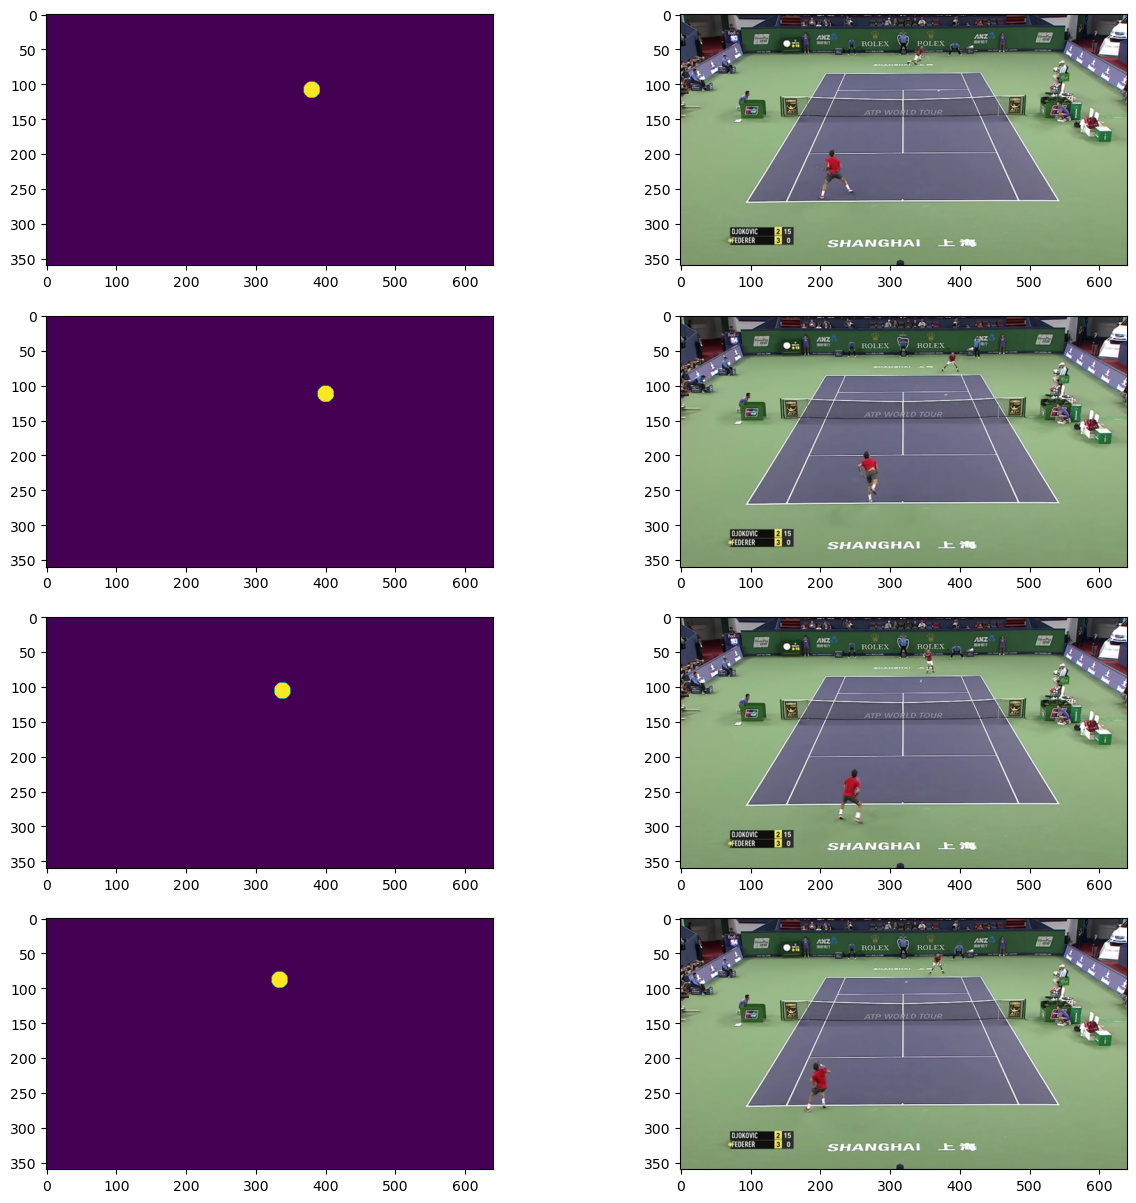

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,15))
for i in range(1,5):
    plt.subplot(4,2,2*i)
    plt.imshow(imgs[i-1,:,:,0:3])
for i in range(1,5):
    plt.subplot(4,2,2*i-1)
    plt.imshow(masks[i-1,:,:]) 

In [11]:
# import matplotlib.pyplot as plt

# stack_s = 3
# train_gen = DataGenerator(Path('../input/tennistrackingassignment/train/'), [1], stack_s=stack_s, downscale=True, pool_s=10, pool_update_s=4, quiet=False)
# stack, mask = train_gen.get_random_stack()
# print(stack.shape, mask.shape)

## Класс Metrics
Класс для вычисления метрики качества трекинга SiBaTrAcc. Функция evaluate_predictions принимает массив из референсных и предсказанных координат мяча для клипа и возвращает массив аккумулированных значений SiBaTrAcc (может быть полезно для визуализации результатов предсказания) и итоговое значение метрики SiBaTrAcc.

In [9]:
class Metrics:

    @staticmethod
    def position_error(label_gt: np.ndarray, label_pr: np.ndarray, step=8, alpha=1.5, e1=5, e2=5):
        # gt codes:
        # 0 - the ball is not within the image
        # 1 - the ball can easily be identified
        # 2 - the ball is in the frame, but is not easy to identify
        # 3 - the ball is occluded
        if label_gt[0] != 0 and label_pr[0] == 0:
            return e1
        if label_gt[0] == 0 and label_pr[0] != 0:
            return e2
        dist = math.sqrt((label_gt[1] - label_pr[1]) ** 2 + (label_gt[2] - label_pr[2]) ** 2)
        pe = math.floor(dist / step) ** alpha
        pe = min(pe, 5)
        return pe

    @staticmethod
    def evaluate_predictions(labels_gt, labels_pr) -> Tuple[List[float], float]:
        pe = [Metrics.position_error(labels_gt[i, ...], labels_pr[i, ...]) for i in range(len(labels_gt))]
        SIBATRACC = []
        for i, _ in enumerate(pe):
            SIBATRACC.append(1 - sum(pe[: i + 1]) / ((i + 1) * 5))
        SIBATRACC_total = 1 - sum(pe) / (len(labels_gt) * 5)
        return SIBATRACC, SIBATRACC_total


## Основной класс модели SuperTrackingModel

Реализует всю логику обучения, сохранения, загрузки и тестирования разработанной модели трекинга. Этот класс можно и нужно расширять.

В качестве примера вам предлагается заготовка модели, в которой трекинг осуществляется за счет предсказания маски по входному батчу и последующему предсказанию координат мяча по полученной маски. В данном варианте вызов функции предсказания координат по клипу (predict) повлечет за собой разбиение клипа на батчи, вызов предсказания маски для каждого батча, склеивание результатов в последовательность масок, вызов функции по вычислению координат мяча по маскам и возвращения результата. Описанные действия уже реализованы, вам остается только написать функции predict_on_bath и get_labels_from_prediction. Эта же функция predict используется и в вызове функции test, дополнительно вычисляя метрику качества трекинга и при необходимости визуализируя результат тестирования. Обратите внимание, что в результирующем numpy массиве с координатами помимо значений x и y первым значением в каждой строке должно идти значение code (0, если мяча в кадре нет и > 0, если мяч в кадре есть) для корректного вычисления качества трекинга.

<font color="red">
Вам разрешается менять логику работы класса модели, (например, если решение не подразумевает использование масок), но при этом логика и работа функций load и test должна остаться неизменной!
</font>

In [10]:
from keras.models import *
from keras.layers import *
import tensorflow as tf 
import matplotlib.pyplot as plt

In [10]:
tf.__version__

'2.10.0-dev20220710'

In [11]:
def build_track_net( n_classes=256, input_height=360, input_width=640): # input_height = 360, input_width = 640
    imgs_input = Input(shape=(input_height,input_width, 9))
#layer1
    x = Conv2D(64, (3, 3), kernel_initializer='random_uniform', padding='same' )(imgs_input) 
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer2
    x = Conv2D(64, (3, 3), kernel_initializer='random_uniform', padding='same' )(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer3
    x = MaxPooling2D((2, 2), strides=(2, 2) )(x)
    #layer4
    x = Conv2D(128, (3, 3), kernel_initializer='random_uniform', padding='same' )(x) 
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer5
    x = Conv2D(128, (3, 3), kernel_initializer='random_uniform', padding='same')(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer6
    x = MaxPooling2D((2, 2), strides=(2, 2) )(x)
    #layer7
    x = Conv2D(256, (3, 3), kernel_initializer='random_uniform', padding='same' )(x) 
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer8
    x = Conv2D(256, (3, 3), kernel_initializer='random_uniform', padding='same' )(x) 
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer9
    x = Conv2D(256, (3, 3), kernel_initializer='random_uniform', padding='same' )(x) 
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer10
    x = MaxPooling2D((2, 2), strides=(2, 2) )(x)
    #layer11
    x = ( Conv2D(512, (3, 3), kernel_initializer='random_uniform', padding='same'))(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer12
    x = ( Conv2D(512, (3, 3), kernel_initializer='random_uniform', padding='same'))(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer13
    x = ( Conv2D(512, (3, 3), kernel_initializer='random_uniform', padding='same'))(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer14
    x = ( UpSampling2D( (2,2)))(x)
    #layer15
    x = ( Conv2D( 256, (3, 3), kernel_initializer='random_uniform', padding='same'))(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer16
    x = ( Conv2D( 256, (3, 3), kernel_initializer='random_uniform', padding='same'))(x) 
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer17
    x = ( Conv2D( 256, (3, 3), kernel_initializer='random_uniform', padding='same'))(x) 
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer18
    x = ( UpSampling2D( (2,2)))(x)
    #layer19
    x = ( Conv2D( 128 , (3, 3), kernel_initializer='random_uniform', padding='same'))(x) 
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer20
    x = ( Conv2D( 128 , (3, 3), kernel_initializer='random_uniform', padding='same' ))(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer21
    x = ( UpSampling2D( (2,2)))(x)
    #layer22
    x = ( Conv2D( 64 , (3, 3), kernel_initializer='random_uniform', padding='same'))(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer23
    x = ( Conv2D( 64 , (3, 3), kernel_initializer='random_uniform', padding='same'))(x) 
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    #layer24
    x =  Conv2D( n_classes , (3, 3) , kernel_initializer='random_uniform', padding='same')(x)
    x = ( Activation('relu'))(x)
    x = ( BatchNormalization())(x)
    o_shape = Model(imgs_input , x ).output_shape
    #layer24 output shape: 360,640,256

    OutputHeight = o_shape[1]
    OutputWidth = o_shape[2]

    #reshape the size to (360*640,256)
    x = (Reshape(( OutputHeight*OutputWidth , -1)))(x)

    #layer25
    gaussian_output = (Activation('softmax'))(x)

    model = Model( imgs_input , gaussian_output)
    model.outputWidth = OutputWidth
    model.outputHeight = OutputHeight

    #show model's details
#     model.summary()
    return model

In [12]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self,show_predictions):
        self.show_predictions=show_predictions
        
    def on_train_end(self,epoch,logs=None):
        self.show_predictions()
        print('Some prediction show after 20 epoch traning')

In [13]:
model_output_height = 360
model_output_width = 640
n_classes = 256 

In [20]:
class SuperTrackingModel:

    def __init__(self, batch_s, stack_s, out_path, downscale):
        self.batch_s = batch_s
        self.stack_s = stack_s
        self.out_path = out_path
        self.downscale = downscale
        self.model = build_track_net()
        self.history = None 
        
    def save(self,name):
        self.model.save(f'/kaggle/working/{name}.h5')
        
    def load(self):
        url = f'https://drive.google.com/uc?export=download&confirm=pbef&id=1n3Olc4T6jxbctXkaXyLCvM_UamgbWx_i'
        name = 'model'
        gdown.download(url, quiet=False, output=name, use_cookies=False) 
        self.model = tf.keras.models.load_model(name)

    def predict_on_batch(self, batch: np.ndarray) -> np.ndarray:

        predictions = self.model.predict(batch)
        res = np.zeros(batch.shape[:3])
        for i in range(batch.shape[0]):
            res[i] = self.create_mask(predictions[i])
            
        return res
        
    def _predict_prob_on_clip(self, clip: np.ndarray) -> np.ndarray:
        print('doing predictions')
        n_frames = clip.shape[0]
        # --- get stacks ---
        stacks = []
        for i in range(n_frames - self.stack_s + 1):
            stack = clip[i : i + self.stack_s, ...]
            stack = np.squeeze(np.split(stack, self.stack_s, axis=0))
            stack = np.concatenate(stack, axis=-1)
            stacks.append(stack)
        # --- round to batch size ---
        add_stacks = 0
        while len(stacks) % self.batch_s != 0:
            stacks.append(stacks[-1])
            add_stacks += 1
        # --- group into batches ---
        batches = []
        for i in range(len(stacks) // self.batch_s):
            batch = np.stack(stacks[i * self.batch_s : (i + 1) * self.batch_s])
            batches.append(batch)
        stacks.clear()
        # --- perform predictions ---
        predictions = []
        for batch in batches:
            pred = np.squeeze(self.predict_on_batch(batch))
            predictions.append(pred)
        # --- crop back to source length ---
        predictions = np.concatenate(predictions, axis=0)
        if (add_stacks > 0):
            predictions = predictions[:-add_stacks, ...]
        batches.clear()
        # --- add (stack_s - 1) null frames at the begining ---
        start_frames = np.zeros((stack_s - 1, predictions.shape[1], predictions.shape[2]), dtype=np.float32)
        predictions = np.concatenate((start_frames, predictions), axis=0)
        print('predictions are made')        
        return predictions

    def get_center_coor(self,mask):
        nozero_ind = np.nonzero(mask)
        if nozero_ind[0].shape ==(0,) or nozero_ind[1].shape ==(0,):
            return 0,0
            
        y,x = np.mean(nozero_ind,axis=1).astype('int')
        return x,y
        
    
    def get_labels_from_prediction(self, pred_prob: np.ndarray, upscale_coords: bool) -> np.ndarray:
        n_frames = pred_prob.shape[0]
        coords = np.zeros([n_frames, 3])
        for i in range(n_frames):
            curr_mask = pred_prob[i]
            if len(np.unique(curr_mask)) > 1:
                coords[i, 0] = 1  
                x, y = self.get_center_coor(curr_mask)
                if upscale_coords==True:
                    x = 2*x
                    y = 2*y
                if x == 0 or y == 0 and i > 0:
                    k=1
                    while True:
                        if i-k==0:
                            coords[i,1],coords[i,2] = coords[i-k,1],coords[i-k,2]
                            break
                        if coords[i-k,1]==0 or coords[i-k,1]==0:
                            k =k+1
                        else: 
                            coords[i,1],coords[i,2] = coords[i-k,1],coords[i-k,2]
                            break
                        
#                     coords[i, 1], coords[i, 2] = coords[i-1, 1], coords[i-1, 2]
                else:
                    coords[i, 1], coords[i, 2] = x, y
                    
        return coords

    def predict(self, clip: np.ndarray, upscale_coords=True) -> np.ndarray:
        prob_pr = self._predict_prob_on_clip(clip)
        labels_pr = self.get_labels_from_prediction(prob_pr, upscale_coords)
        return labels_pr, prob_pr

    def test(self, data_path: Path, games: List[int], do_visualization=False, test_name='test'):
        game_clip_pairs = get_game_clip_pairs(data_path, games)
        SIBATRACC_vals = []
        for game, clip in game_clip_pairs:
            data = load_clip_data(data_path, game, clip, downscale=self.downscale)
            if do_visualization:
                data_full = load_clip_data(data_path, game, clip, downscale=False) if self.downscale else data
            labels_gt = load_clip_labels(data_path, game, clip, downscale=False)
            labels_pr, prob_pr = self.predict(data)
            SIBATRACC_per_frame, SIBATRACC_total = Metrics.evaluate_predictions(labels_gt, labels_pr)
            SIBATRACC_vals.append(SIBATRACC_total)
            if do_visualization:
                visualize_prediction(data_full, labels_pr, self.out_path, f'{test_name}_g{game}_c{clip}', SIBATRACC_per_frame)
                visualize_prob(data, prob_pr, self.out_path, f'{test_name}_g{game}_c{clip}')
                del data_full
            del data, labels_gt, labels_pr, prob_pr
            gc.collect()
        SIBATRACC_final = sum(SIBATRACC_vals) / len(SIBATRACC_vals)
        return SIBATRACC_final
    
    def show_subplot(self,mask,pre_mask,img):
        fig = plt.figure(figsize=(15,15))
        plt.subplot(131)
        plt.title('Predicted mask')
        plt.imshow(pre_mask)
        plt.subplot(132) 
        plt.title('Ground Truth mask')
        plt.imshow(mask)
        plt.subplot(133) 
        plt.title('Real world img')
        plt.imshow(img)
        
    def create_mask(self,label):
        return label.reshape((360, 640, 256) ).argmax( axis=2 )
    
    def show_predictions(self,random_batch=None):
        if(random_batch == None):
            imgs, masks = self.val_generator.get_random_batch(self.batch_s)
        else:
            imgs, masks = random_batch(self.batch_s)
            
        res =self.model.predict(imgs)
        pr = res[0]
        pr = self.create_mask(pr)
        mask = self.create_mask(masks[0,:,:])
        self.show_subplot(mask,pr,imgs[0,:,:,6:9])
        pr = res[1]
        pr = self.create_mask(pr)
        mask = self.create_mask(masks[1,:,:])
        self.show_subplot(mask,pr,imgs[1,:,:,6:9])
        
        return
    #LBL6.Построение графиков, визуализирующих процесс обучения (график зависимости функции потерь от номера эпохи обучения, и т.п.)
    def train_plot(self):
        if self.history is None:
            print("model has not been trained")
            return
        
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']
        epochs = range(len(acc))
        plt.plot(epochs,acc,'*',label = "Training accuracy")
        plt.plot(epochs,val_acc,'b',label="Validation accuracy")
        plt.title("Training and validation accuracy")
        plt.legend()
        plt.figure()
        
        plt.plot(epochs,loss,'bo',label = "Training Loss")
        plt.plot(epochs,val_loss,'b',label = "Validation Loss")
        plt.title("training and validation loss")
        plt.legend()
        plt.xlabel('Epoch')
        plt.show()
    
    def train(self,train_generator,val_generator,epoch=20):
        # todo: implement model training here
        self.model.compile(loss='categorical_crossentropy',
                           optimizer= tf.keras.optimizers.Adadelta(learning_rate=1.0), metrics=['accuracy'])
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)
        self.train_generator = train_generator
        self.val_generator = val_generator
        
        #LBL1 Валидация модели на части обучающей выборки
        self.history = self.model.fit(self.train_generator.random_g(self.batch_s),
                                  validation_data=self.val_generator.random_g(self.batch_s),epochs=40,verbose=1,
                                  steps_per_epoch=200,validation_steps=30,
                                      callbacks = [stop_early]
                                     )
        self.show_predictions()
            
        print('Running stub for training model...')
        time.sleep(2)
        print('training done.')

# Test on Best Model 

In [22]:
batch_s = 2
stack_s = 3
downscale = True
output_path = prepare_experiment(Path('/kaggle/working'))
new_model = SuperTrackingModel(batch_s, stack_s, out_path=output_path, downscale=downscale)
new_model.load()
sibatracc_final = new_model.test(Path('../input/tennistrackingassignment/test/'), [1,2], do_visualization=False, test_name='test')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1n3Olc4T6jxbctXkaXyLCvM_UamgbWx_i
To: /kaggle/working/model
100%|██████████| 129M/129M [00:00<00:00, 246MB/s] 


loading clip data (game 1, clip 1) downscaled
loading clip labels (game 1, clip 1)
doing predictions


2022-12-11 12:45:36.231889: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-11 12:45:38.398166: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


predictions are made
loading clip data (game 1, clip 2) downscaled
loading clip labels (game 1, clip 2)
doing predictions
predictions are made
loading clip data (game 1, clip 3) downscaled
loading clip labels (game 1, clip 3)
doing predictions
predictions are made
loading clip data (game 1, clip 4) downscaled
loading clip labels (game 1, clip 4)
doing predictions
predictions are made
loading clip data (game 1, clip 5) downscaled
loading clip labels (game 1, clip 5)
doing predictions
predictions are made
loading clip data (game 1, clip 6) downscaled
loading clip labels (game 1, clip 6)
doing predictions
predictions are made
loading clip data (game 1, clip 7) downscaled
loading clip labels (game 1, clip 7)
doing predictions
predictions are made
loading clip data (game 1, clip 8) downscaled
loading clip labels (game 1, clip 8)
doing predictions
predictions are made
loading clip data (game 2, clip 1) downscaled
loading clip labels (game 2, clip 1)
doing predictions
predictions are made
loa

In [23]:
print(f'SiBaTrAcc final value: {sibatracc_final}')

SiBaTrAcc final value: 0.8604674591072365


In [15]:
#'../input/tennistrackingassignment/train/'

# Some details of Training 

In [16]:
batch_s = 2
stack_s = 3
downscale = True
output_path = prepare_experiment(Path('/kaggle/working'))
model = SuperTrackingModel(batch_s,stack_s,output_path,True)

In [16]:

# train_gen = DataGenerator(Path('../input/tennistrackingassignment/train/'), [1, 2, 3], stack_s=stack_s, downscale=True, pool_s=8, pool_update_s=4, quiet=True,one_hot=True)
# val_gen = DataGenerator(Path('../input/tennistrackingassignment/train/'), [1,2], stack_s=stack_s, downscale=True, pool_s=4, pool_update_s=2, quiet=True,one_hot=True)
# Load the trained model and try another combination of Train data
train_gen = DataGenerator(Path('train/'), [1, 2, 3,4,5], stack_s=stack_s, downscale=True, pool_s=8, pool_update_s=4, quiet=True,one_hot=True)
val_gen = DataGenerator(Path('train/'), [6], stack_s=stack_s, downscale=True, pool_s=4, pool_update_s=2, quiet=True,one_hot=True)

In [17]:
#LBL4 Загрузка модели с какой-то конкретной итерации обучения (если используется итеративное обучение)
model.model = tf.keras.models.load_model('C:\kaggle\working\\After70epoch.h5')

1/1 [==============================] - 7s 7s/step


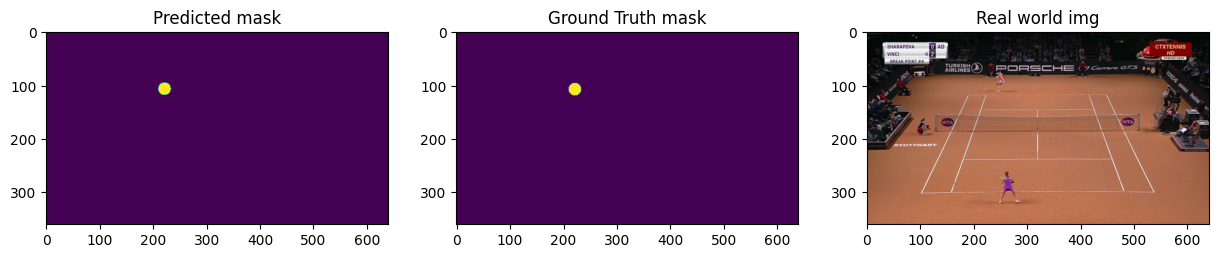

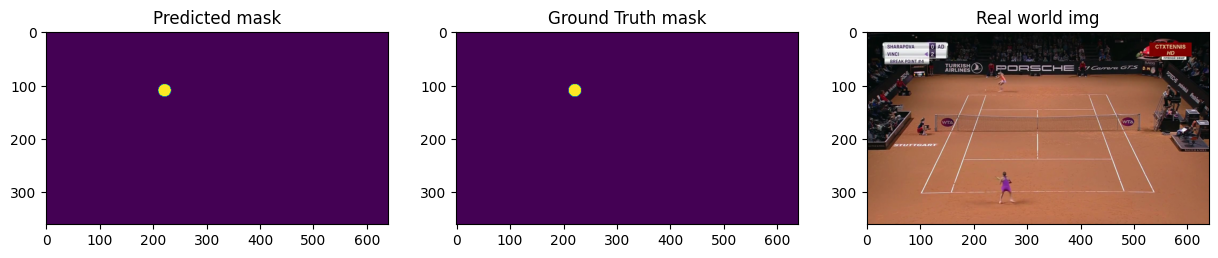

In [18]:
model.show_predictions(val_gen.get_random_batch)

Пример пайплайна для тестирования обученной модели:

Epoch 1/40

200/200 [==============================] - 470s 2s/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0020 - val_accuracy: 0.9993

Epoch 2/40

200/200 [==============================] - 464s 2s/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0037 - val_accuracy: 0.9993

Epoch 3/40

200/200 [==============================] - 481s 2s/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0253 - val_accuracy: 0.9981

Epoch 4/40

200/200 [==============================] - 506s 3s/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0050 - val_accuracy: 0.9989

Epoch 5/40

200/200 [==============================] - 505s 3s/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0040 - val_accuracy: 0.9993

Epoch 6/40

200/200 [==============================] - 524s 3s/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0036 - val_accuracy: 0.9993

Epoch 7/40

200/200 [==============================] - 507s 3s/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.0321 - val_acc

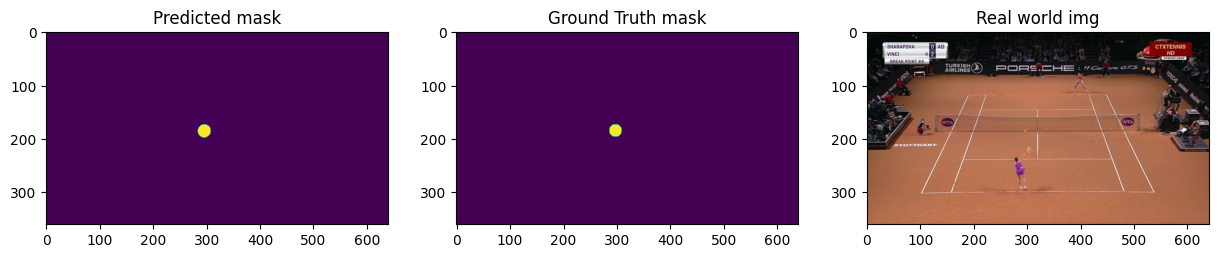

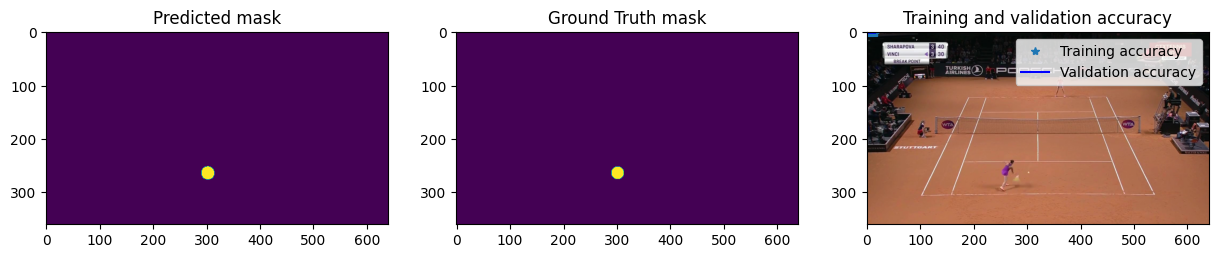

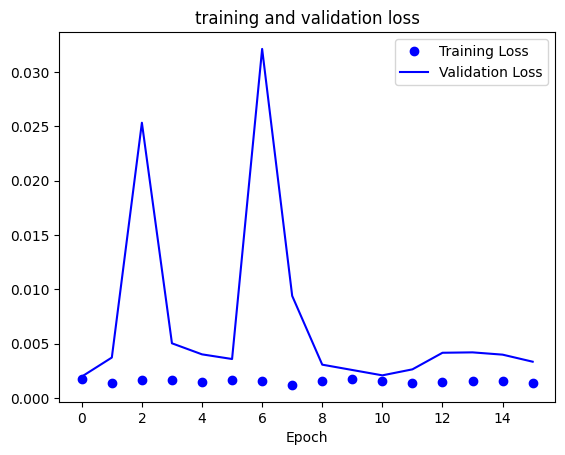

In [19]:
#LBL5.Вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе)
# Training information from 140 epoch to 180 epoches
model.train(train_gen, val_gen)
model.train_plot() 

Epoch 1/40

200/200 [==============================] - 424s 2s/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0038 - val_accuracy: 0.9992

Epoch 2/40

200/200 [==============================] - 418s 2s/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0044 - val_accuracy: 0.9992

Epoch 3/40

200/200 [==============================] - 417s 2s/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0060 - val_accuracy: 0.9992

Epoch 4/40

200/200 [==============================] - 418s 2s/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0060 - val_accuracy: 0.9991

Epoch 5/40

200/200 [==============================] - 419s 2s/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0040 - val_accuracy: 0.9992

Epoch 6/40

200/200 [==============================] - 424s 2s/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0042 - val_accuracy: 0.9991

Epoch 7/40

200/200 [==============================] - 418s 2s/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0050 - val_acc

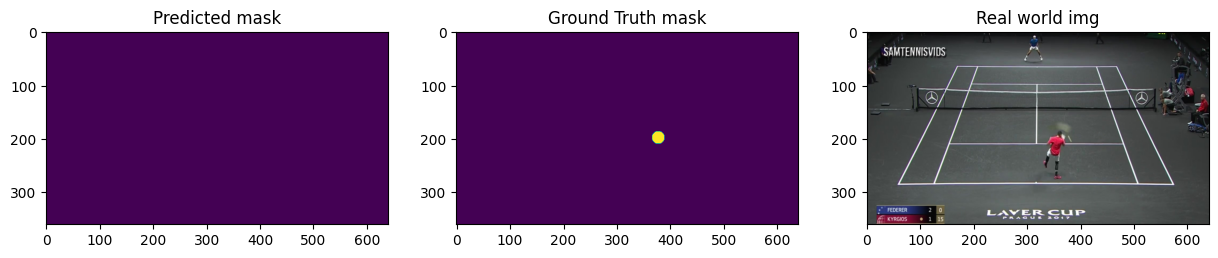

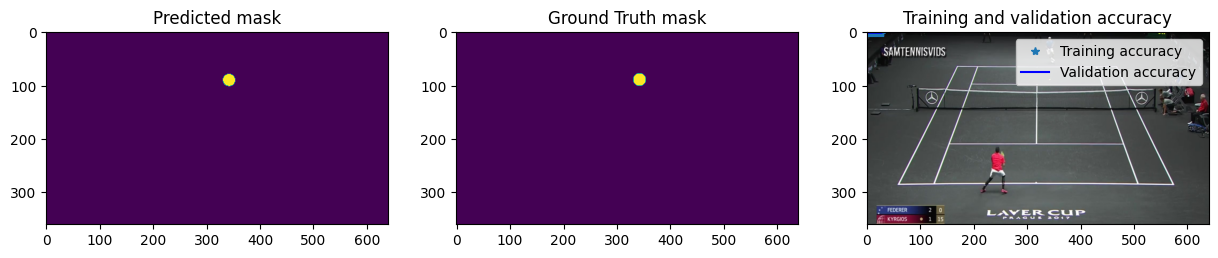

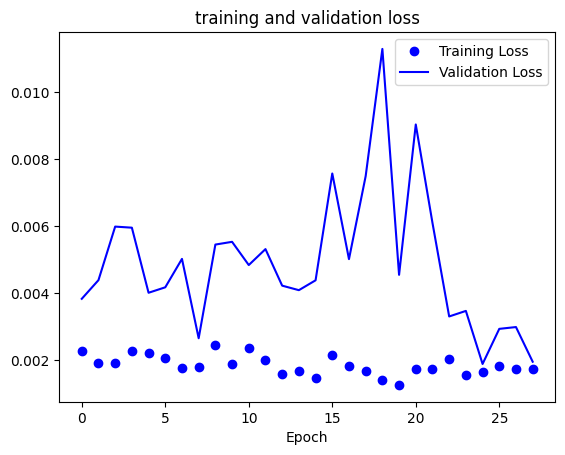

In [22]:
# Training information from 110 epoch to 140 epoches
model.train(train_gen, val_gen)
model.train_plot() 

Epoch 1/20

100/100 [==============================] - 309s 3s/step - loss: 0.0058 - accuracy: 0.9993 - val_loss: 0.0064 - val_accuracy: 0.9991

Epoch 2/20

100/100 [==============================] - 261s 3s/step - loss: 0.0056 - accuracy: 0.9992 - val_loss: 0.0150 - val_accuracy: 0.9985

Epoch 3/20

100/100 [==============================] - 260s 3s/step - loss: 0.0050 - accuracy: 0.9993 - val_loss: 0.0060 - val_accuracy: 0.9992

Epoch 4/20

100/100 [==============================] - 262s 3s/step - loss: 0.0043 - accuracy: 0.9994 - val_loss: 0.0112 - val_accuracy: 0.9986

Epoch 5/20

100/100 [==============================] - 263s 3s/step - loss: 0.0044 - accuracy: 0.9993 - val_loss: 0.0082 - val_accuracy: 0.9987

Epoch 6/20

100/100 [==============================] - 264s 3s/step - loss: 0.0044 - accuracy: 0.9993 - val_loss: 0.0043 - val_accuracy: 0.9991

Epoch 7/20

100/100 [==============================] - 272s 3s/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 0.0059 - val_acc

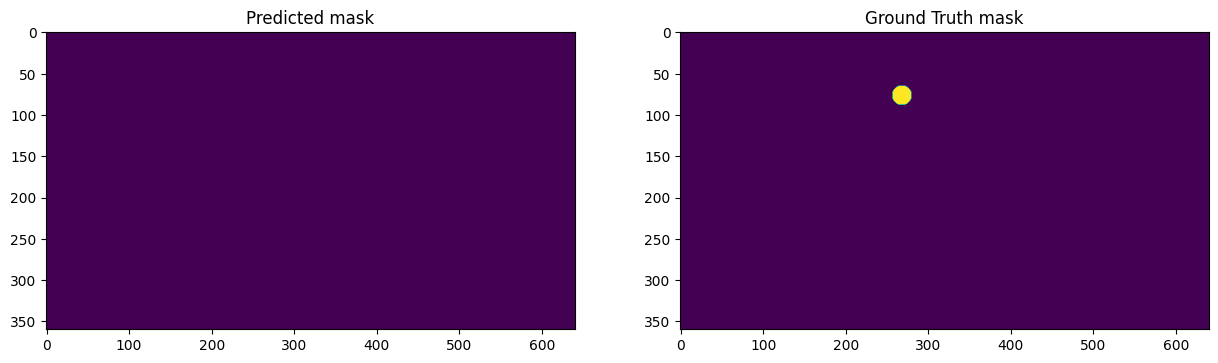

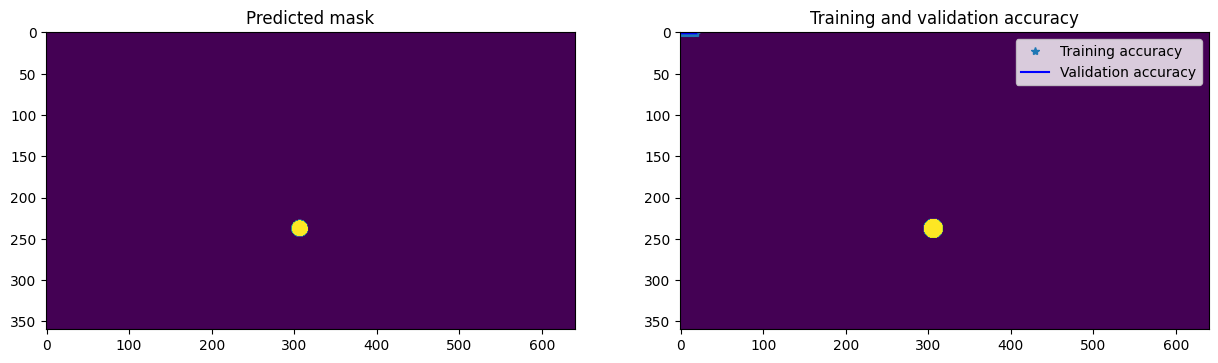

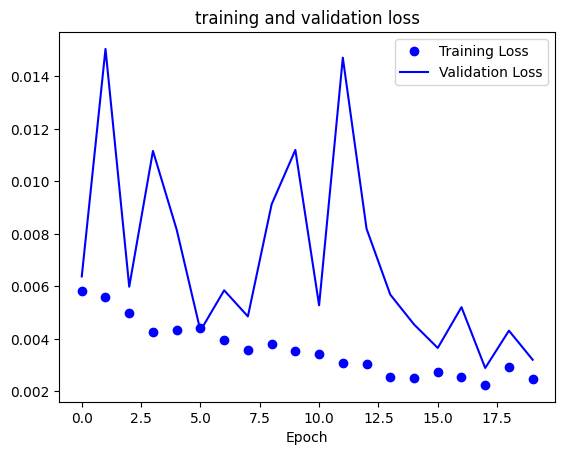

Running stub for training model...

training done.


In [25]:
# Training information from 50 epoch to 70 epoches
model.train(train_gen, val_gen)

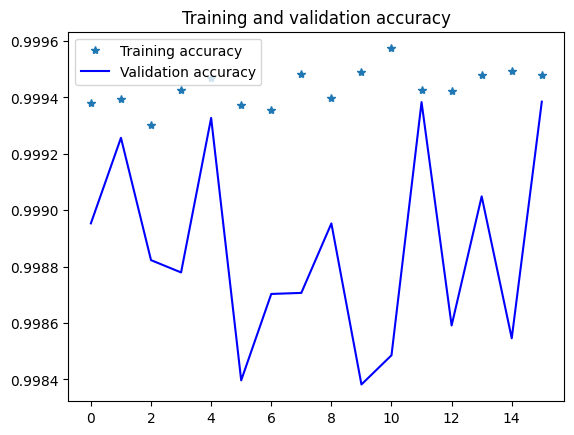

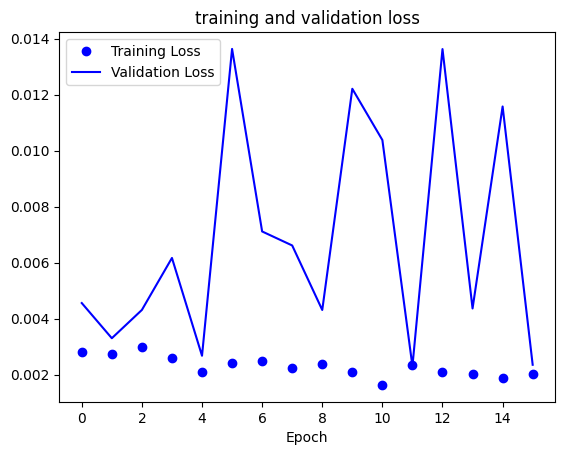

1/1 [==============================] - 0s 23ms/step


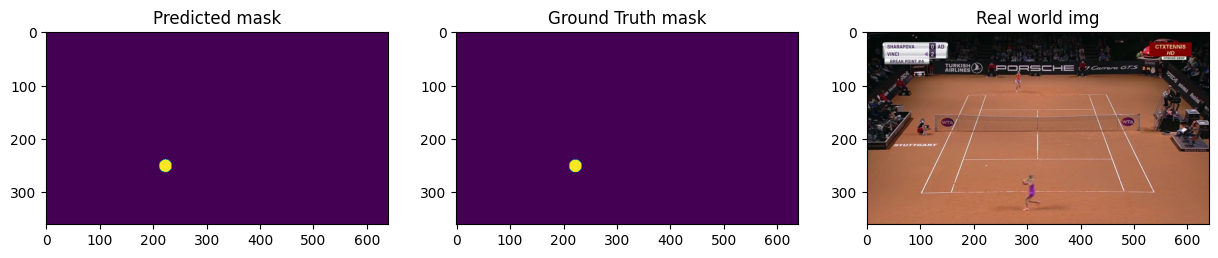

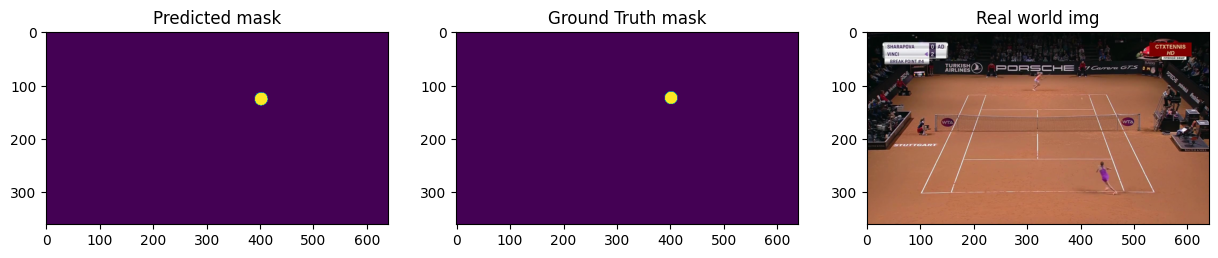

In [28]:
# Training information from 70 epoch to 110 epoches
model.train(train_gen, val_gen)
model.train_plot() 
model.show_predictions(val_gen.get_random_batch)

In [18]:
#LBL7.Автоматическое тестирование на тестовом наборе/наборах данных после каждой или после некоторых эпох обучения (при использовании итеративного обучения)
sibatracc_final = model.test(Path('test/'), [1,2], do_visualization=True, test_name='test')
print(f'SiBaTrAcc final value: {sibatracc_final}')

loading clip data (game 1, clip 1) downscaled

loading clip data (game 1, clip 1) 

loading clip labels (game 1, clip 1)

doing predictions

1/1 [==============================] - 7s 7s/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 24ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 22ms/step

1/1 [==============================] - 0s 17ms/step

1/1 [========

In [21]:
model.save('best')

In [16]:
# %cd /kaggle/working/
# # !zip -r "exp_5.zip" "exp_5"
# from IPython.display import FileLink
# FileLink(r'test.h5')

/kaggle/working


/kaggle/working/test.h5

In [17]:
# output_path = prepare_experiment(Path('/kaggle/working'))
# new_model = SuperTrackingModel(batch_s, stack_s, out_path=output_path, downscale=True)

In [73]:
# new_model.model = tf.keras.models.load_model('/kaggle/working/my_model.h5')

Во время самостоятельного тестирования попробуйте хотя бы раз сделать тестирование с визуализацией (do_visualization=True), чтобы визуально оценить качество трекинга разработанной моделью.

<font color=red>
Загрузка модели через функцию load должна происходить полностью автоматически без каких-либо действий со стороны пользователя! Один из вариантов подобной реализации с использованием google drive и пакета gdown приведен в разделе с дополнениями.
</font>

## Дополнения

Иногда при записи большого количества файлов в output директорию kaggle может "тупить" и не отображать корректно структуру дерева файлов в output и не показывать кнопки для скачивания выбранного файла. В этом случае удобно будет запаковать директорию с экспериментом и выкачать ее вручную. Пример для выкачивания директории с первым экспериментом приведен ниже:

In [ ]:
from IPython.display import FileLink


In [18]:
%cd /kaggle/working/
# !zip -r "exp_5.zip" "exp_5"
from IPython.display import FileLink
FileLink(r'test.h5')

/kaggle/working


/kaggle/working/test.h5

удалить лишние директории или файлы в output тоже легко:

In [ ]:
!rm -r /kaggle/working/exp_1

Для реализации загрузки данных рекомендуется использовать облачное хранилище google drive и пакет gdown для скачивания файлов. Пример подобного использования приведен ниже:
1. загружаем файл в google drive (в данном случае, это npz архив, содержащий один numpy массив по ключу 'w')
2. в интерфейсе google drive открываем доступ на чтение к файлу по ссылке и извлекаем из ссылки id файла
3. формируем url для скачивания файла
4. с помощью gdown скачиваем файл
5. распаковываем npz архив и пользуемся numpy массивом

<font color="red">
Обратите внимание, что для корректной работы нужно правильно определить id файла. В частности, в ссылке https://drive.google.com/file/d/1kZ8CC-zfkB_TlwtBjuPcEfsPV0Jz7IPA/view?usp=sharing id файла заключен между ...d/ b /view?... и равен 1kZ8CC-zfkB_TlwtBjuPcEfsPV0Jz7IPA
</font>

In [ ]:
import gdown

id = '1kZ8CC-zfkB_TlwtBjuPcEfsPV0Jz7IPA'
url = f'https://drive.google.com/uc?id={id}'
output = 'sample-weights.npz'
gdown.download(url, output, quiet=False)

import numpy as np

weights = np.load('/kaggle/working/sample-weights.npz')['w']
print(weights)